# Load Data
---

In [1]:
# # !pip install pandas
# # ! pip install matplotlib
# # ! pip install seaborn
# # ! pip install statsmodels
# # !pip install scikit-learn
# # !pip install linearmodels
# !pip install numpy==1.26.4
# !pip install pmdarima==2.0.4
# # !pip uninstall pmdarima -y
# # !pip uninstall numpy -y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Buat datetime index 2 tahun hourly
date_rng = pd.date_range(start='2024-01-01', periods=2*365*24, freq='H')
np.random.seed(42)

# ===== Temperature =====
yearly_temp = 15 + 10 * np.sin(2 * np.pi * date_rng.dayofyear / 365)  
daily_temp = 5 * np.sin(2 * np.pi * date_rng.hour / 24)  
random_weather = np.random.normal(0, 1.5, len(date_rng))
temperature = yearly_temp + daily_temp + random_weather

# ===== Energy Consumption =====
weekday_factor = np.where(date_rng.dayofweek < 5, 1.1, 0.95)  
temp_effect = np.where(temperature < 18, (18 - temperature) * 3, (temperature - 22) * 1.5)  
temp_effect[temp_effect < 0] = 0
base_energy = 200 + temp_effect
energy_consumption = base_energy * weekday_factor + np.random.normal(0, 5, len(date_rng))

# ===== Hot Water =====
morning_peak = np.exp(-0.5 * ((date_rng.hour - 7) / 2) ** 2)  
evening_peak = np.exp(-0.5 * ((date_rng.hour - 20) / 2.5) ** 2)
daily_pattern = 1 + morning_peak + evening_peak
seasonal_temp_effect = np.where(temperature < 18, (18 - temperature) * 0.6, 0)

hot_water = (
    30 + 0.55 * energy_consumption + seasonal_temp_effect
) * daily_pattern + np.random.normal(0, 1.0, len(date_rng))

# ===== Production Quantity (korelasi ~0.8 dengan hot_water) =====
noise_level = 8  # atur besar noise untuk kontrol korelasi
production_quantity = hot_water * 1.2 + np.random.normal(0, noise_level, len(date_rng))

In [3]:
# convert to pandas
data = pd.DataFrame({
    'datetime': date_rng,
    'temperature': temperature,
    'energy': energy_consumption,
    'hot_water': hot_water,
    'production_quantity': production_quantity
})


# set index
data.set_index('datetime', inplace=True)
data.head()

,temperature,energy,hot_water,production_quantity
datetime,,,,
2024-01-01 00:00:00,15.917205,227.474974,156.321825,190.522042
2024-01-01 01:00:00,16.258832,229.348138,159.620375,192.380941
2024-01-01 02:00:00,18.643666,215.707069,153.861451,174.662111
2024-01-01 03:00:00,20.992212,228.477579,175.580024,221.472480
2024-01-01 04:00:00,19.151031,209.764166,192.266680,224.776808


# EDA
---

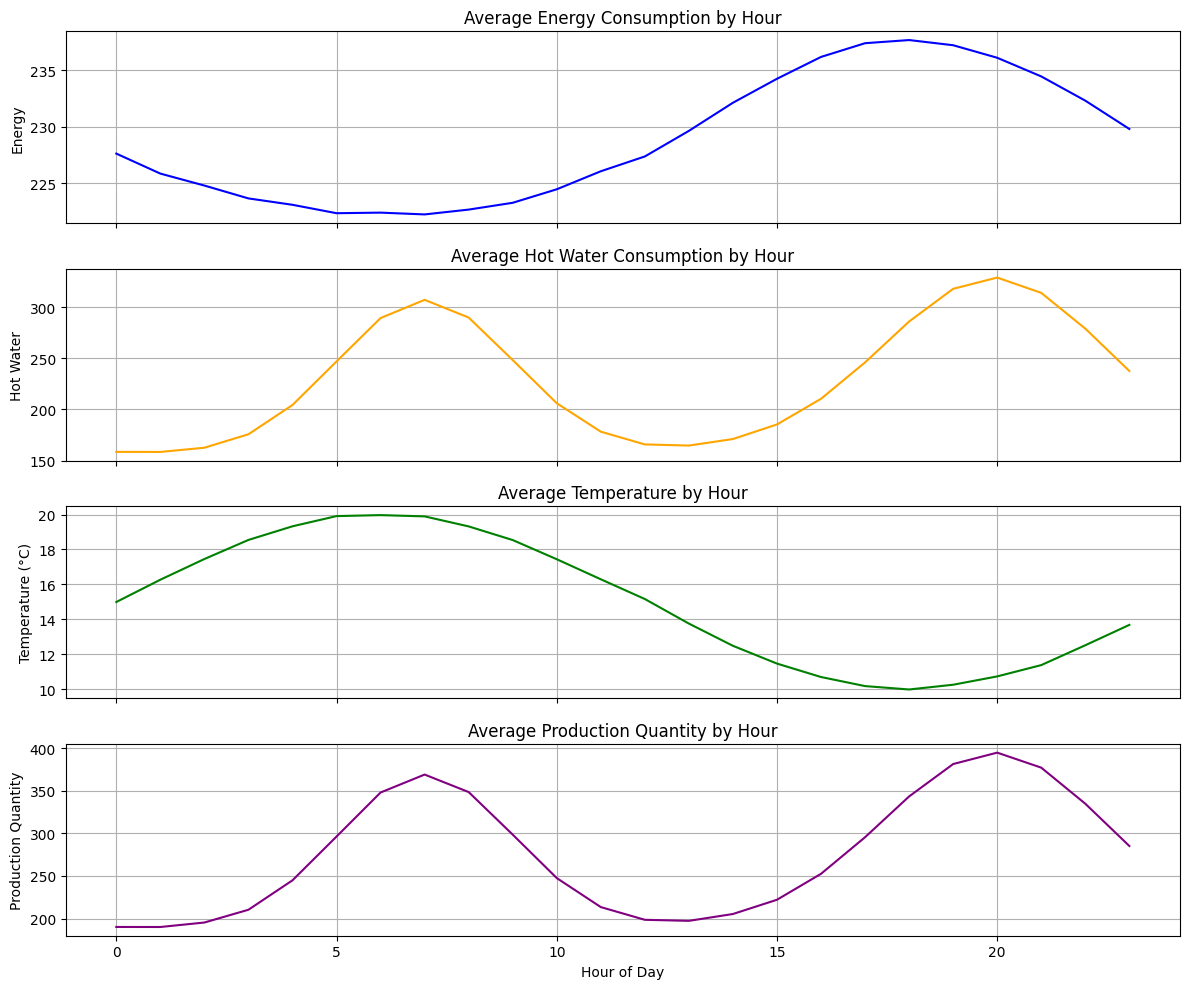

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

# Ambil rata-rata per jam (pola harian rata-rata)
data_hourly = data.copy()
data_hourly['hour'] = data_hourly.index.hour
hourly_mean = data_hourly.groupby('hour').mean()

# Plot line chart
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Energy
sns.lineplot(ax=axes[0], data=hourly_mean, x=hourly_mean.index, y='energy', color='blue')
axes[0].set_title('Average Energy Consumption by Hour')
axes[0].set_ylabel('Energy')
axes[0].grid(True)

# Hot Water
sns.lineplot(ax=axes[1], data=hourly_mean, x=hourly_mean.index, y='hot_water', color='orange')
axes[1].set_title('Average Hot Water Consumption by Hour')
axes[1].set_ylabel('Hot Water')
axes[1].grid(True)


# Temperature
sns.lineplot(ax=axes[2], data=hourly_mean, x=hourly_mean.index, y='temperature', color='green')
axes[2].set_title('Average Temperature by Hour')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Production Quantity
sns.lineplot(ax=axes[3], data=hourly_mean, x=hourly_mean.index, y='production_quantity', color='purple')
axes[3].set_title('Average Production Quantity by Hour')
axes[3].set_xlabel('Hour of Day')
axes[3].set_ylabel('Production Quantity')
axes[3].grid(True)

plt.tight_layout()
plt.show()

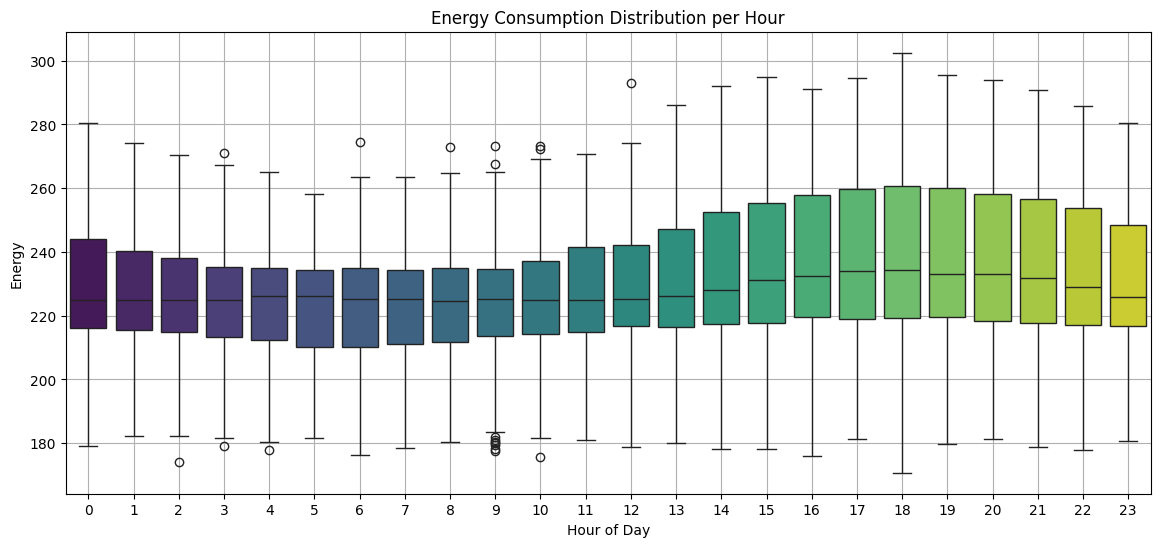

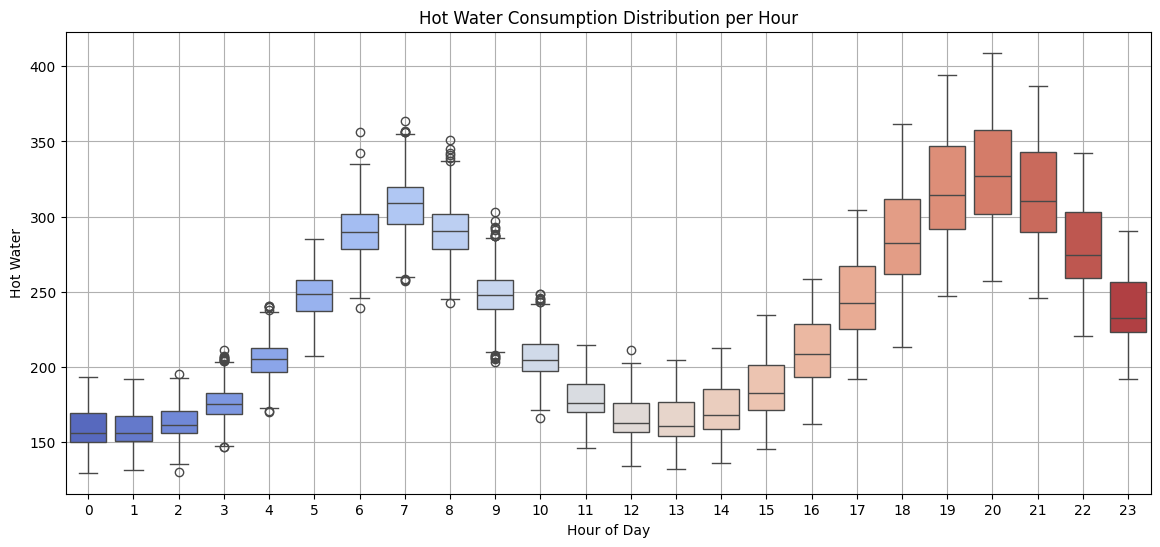

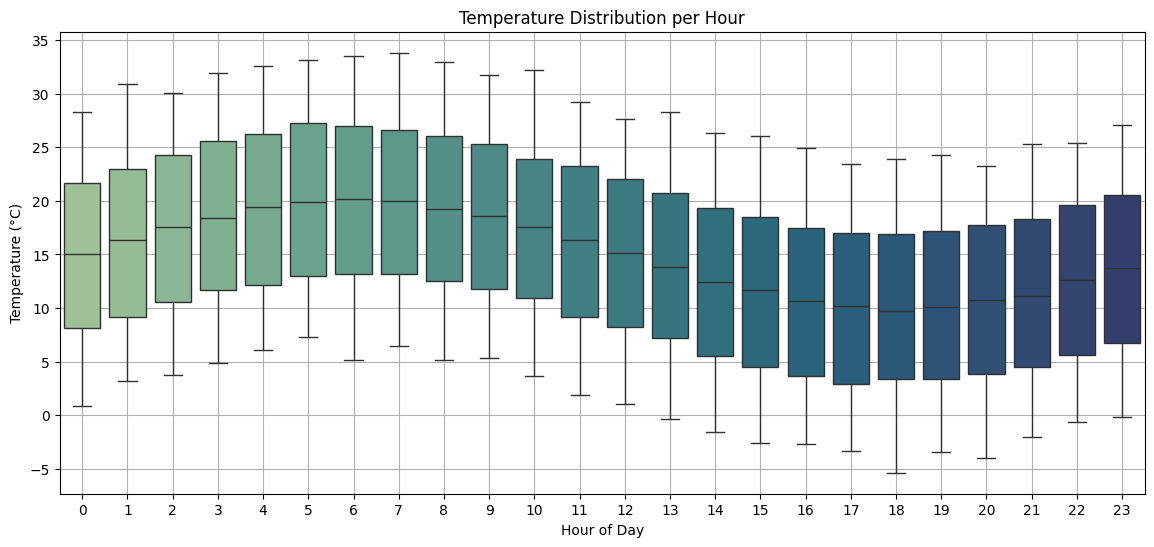

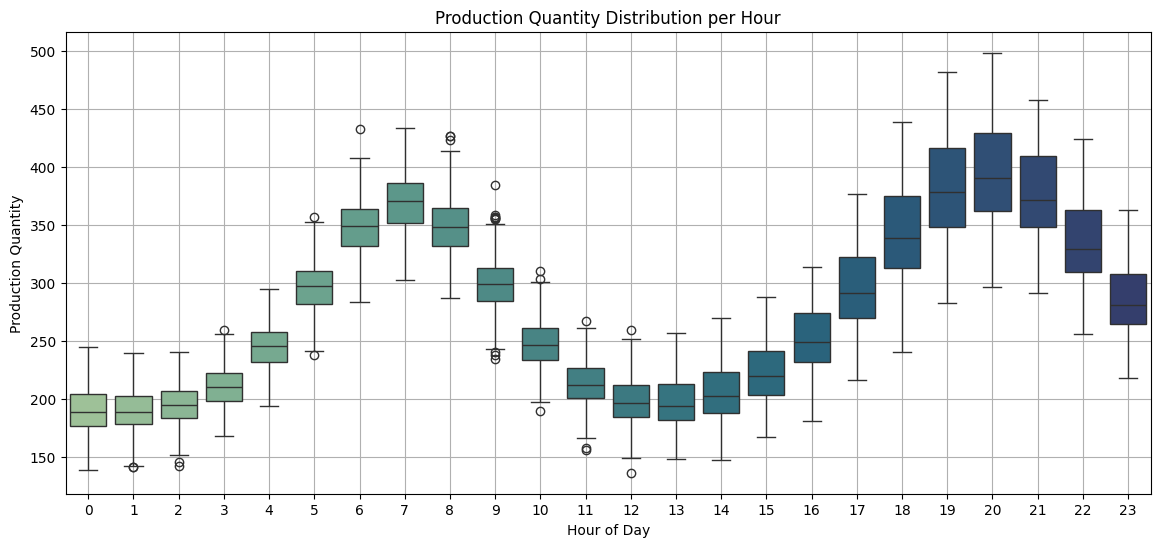

In [5]:
# Tambahkan kolom hour
data_box = data.copy()
data_box['hour'] = data_box.index.hour

# Energy Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_box, x='hour', y='energy', palette='viridis')
plt.title('Energy Consumption Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Energy')
plt.grid(True)
plt.show()

# Hot Water Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_box, x='hour', y='hot_water', palette='coolwarm')
plt.title('Hot Water Consumption Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Hot Water')
plt.grid(True)
plt.show()

# Temperature Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_box, x='hour', y='temperature', palette='crest')
plt.title('Temperature Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Production Quantity Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_box, x='hour', y='production_quantity', palette='crest')
plt.title('Production Quantity Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Production Quantity')
plt.grid(True)
plt.show()

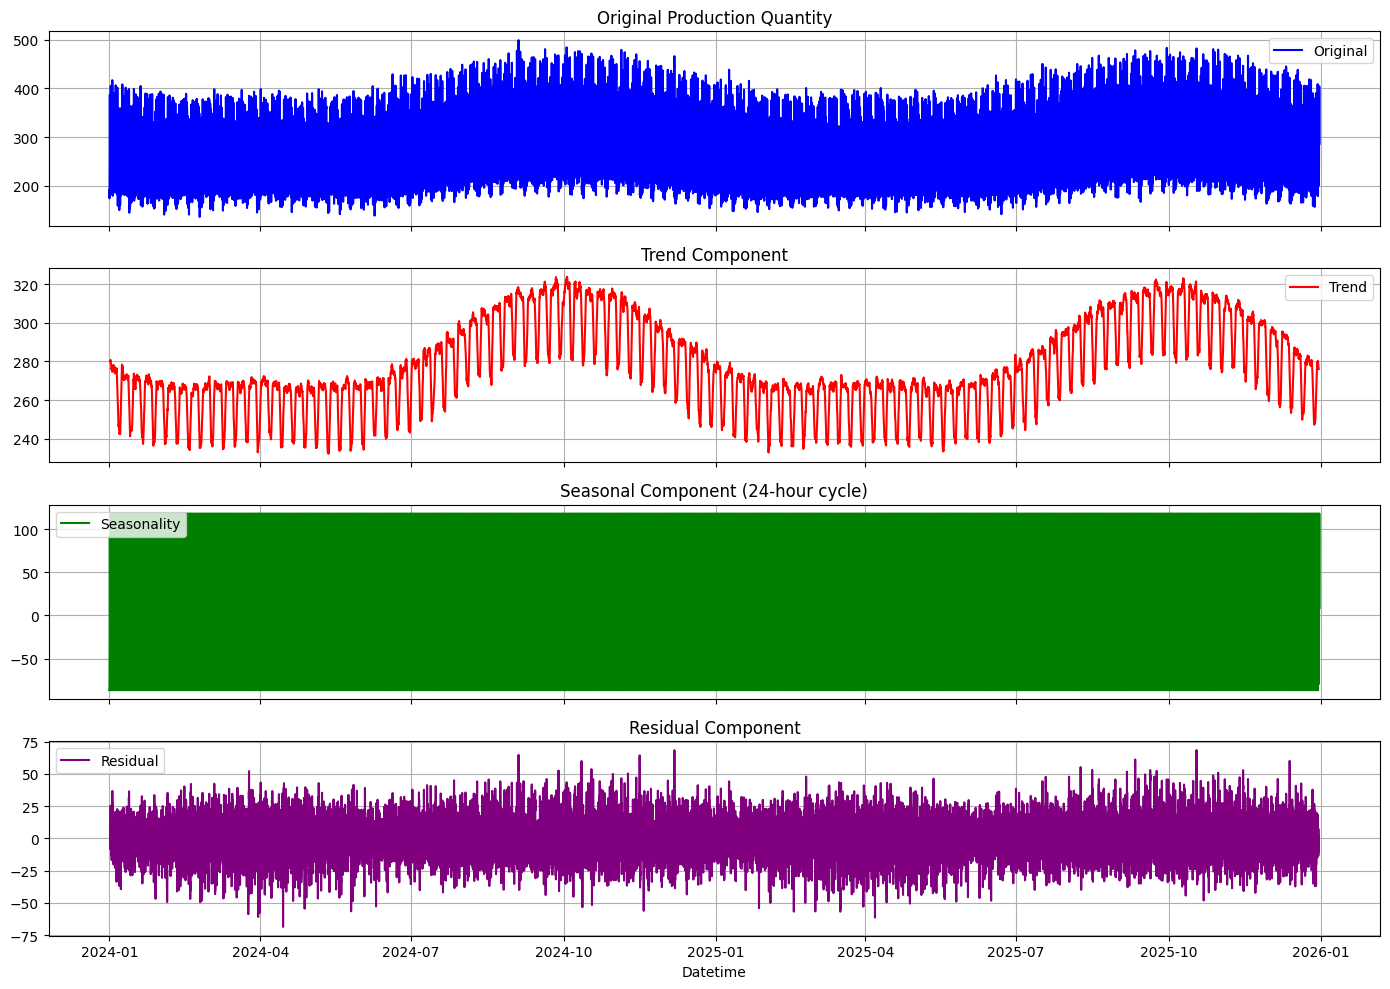

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposition untuk production_quantity
decomposition = seasonal_decompose(data['production_quantity'], model='additive', period=24)

# Extract komponen
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Plot manual
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(data['production_quantity'], label='Original', color='blue')
axes[0].set_title('Original Production Quantity')
axes[0].legend()
axes[0].grid(True)

# Trend
axes[1].plot(trend, label='Trend', color='red')
axes[1].set_title('Trend Component')
axes[1].legend()
axes[1].grid(True)

# Seasonality
axes[2].plot(seasonal, label='Seasonality', color='green')
axes[2].set_title('Seasonal Component (24-hour cycle)')
axes[2].legend()
axes[2].grid(True)

# Residual
axes[3].plot(resid, label='Residual', color='purple')
axes[3].set_title('Residual Component')
axes[3].legend()
axes[3].grid(True)

plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

- Tren cenderung fluktuatif dan konstant
- seasonal 24 jam mempunyai pola yang sama
- residual fluktuasi kecil & acak: Data sudah cukup baik dipisahkan menjadi tren + pola harian

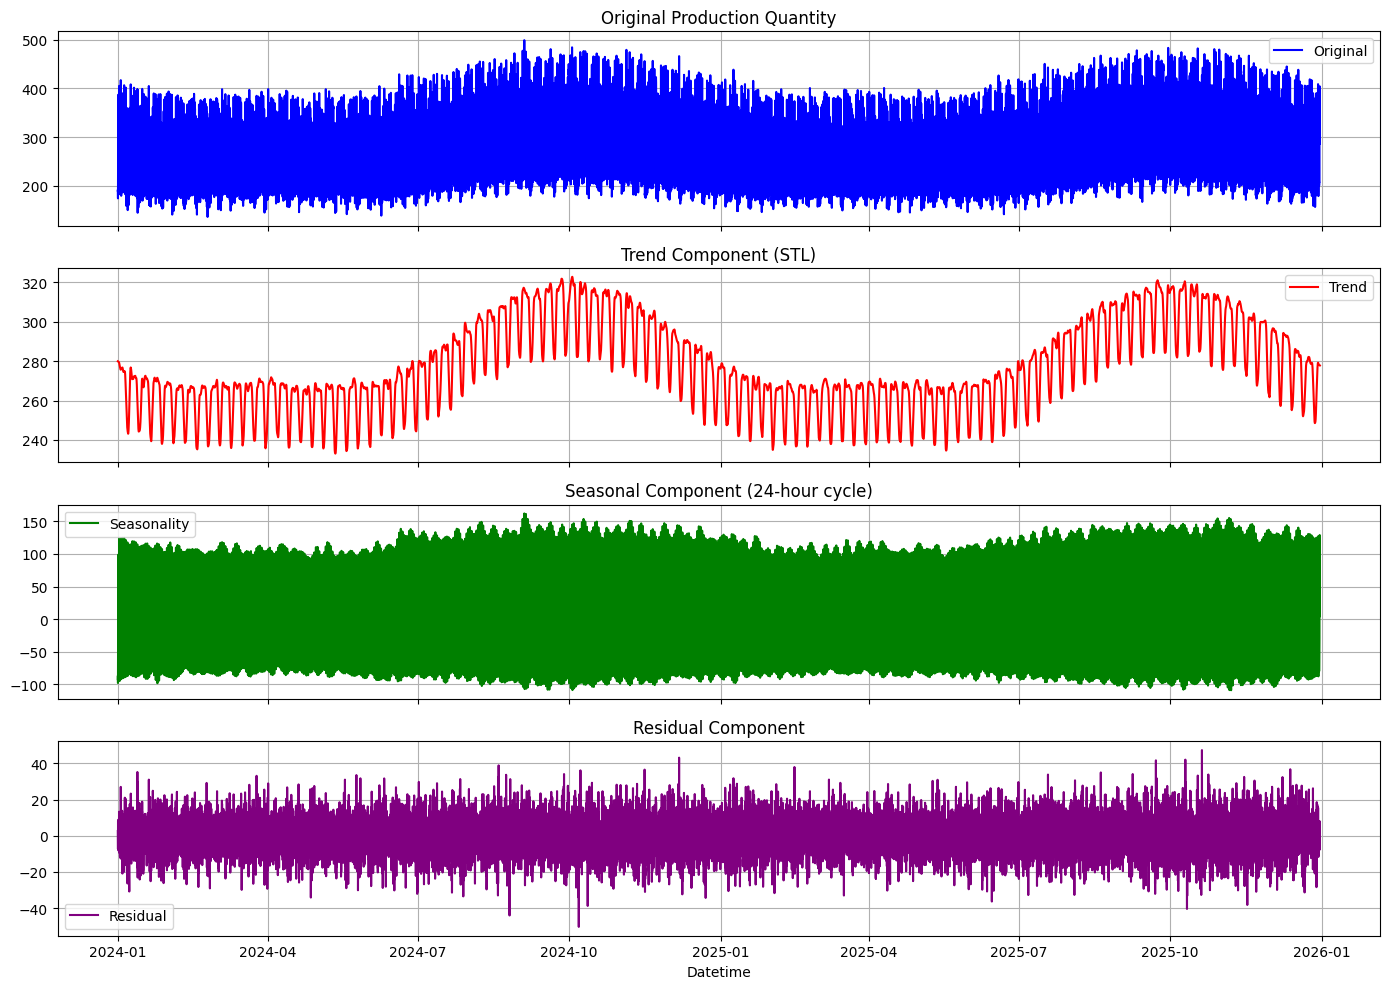

In [7]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(data['production_quantity'], period=24)
result = stl.fit()

# Extract komponen
trend = result.trend
seasonal = result.seasonal
resid = result.resid

# Plot manual
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(data['production_quantity'], label='Original', color='blue')
axes[0].set_title('Original Production Quantity')
axes[0].legend()
axes[0].grid(True)

# Trend
axes[1].plot(trend, label='Trend', color='red')
axes[1].set_title('Trend Component (STL)')
axes[1].legend()
axes[1].grid(True)

# Seasonality
axes[2].plot(seasonal, label='Seasonality', color='green')
axes[2].set_title('Seasonal Component (24-hour cycle)')
axes[2].legend()
axes[2].grid(True)

# Residual
axes[3].plot(resid, label='Residual', color='purple')
axes[3].set_title('Residual Component')
axes[3].legend()
axes[3].grid(True)

plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

Hasil STL cukup mirip hanya saja ada perbedaan significant pada 24 hours.

- seasonal_decompose bekerja dengan metode moving average. Polanya cenderung kaku, sehingga fluktuasi jangka pendek bisa “ikut” dianggap bagian dari trend atau seasonal.Jadi pola terlihat lebih jelas tapi sebenarnya ada kemungkinan beberapa noise ikut dianggap pola.

- STL dengan LOESS melakukan smoothing adaptif. LOESS lebih selektif dalam menahan fluktuasi jangka pendek yang tidak konsisten.Jadi tren dan pola seasonal terlihat lebih halus, dan variasi yang tidak konsisten dipindahkan ke komponen residual.

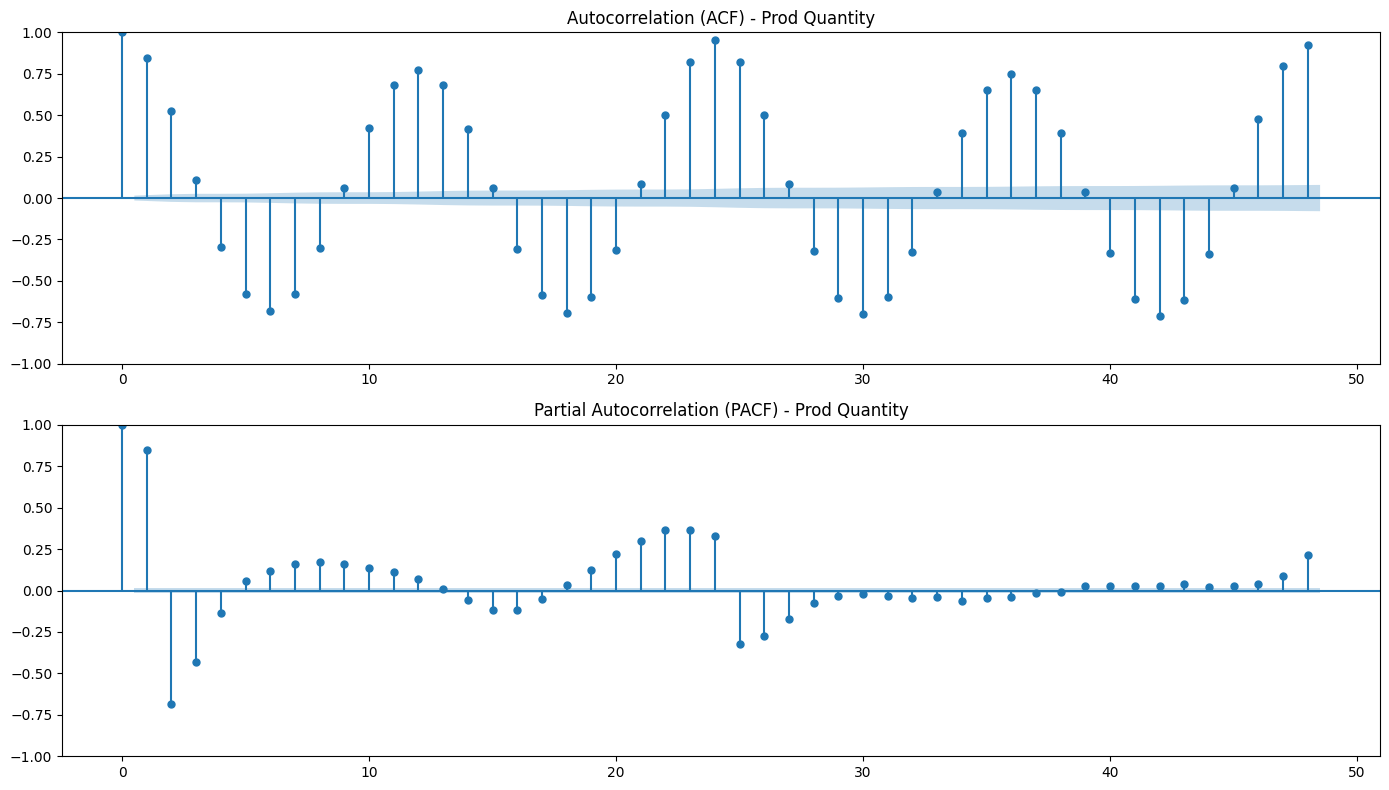

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF dan PACF untuk hot_water
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(data['production_quantity'], lags=48, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF) - Prod Quantity')

# PACF
plot_pacf(data['production_quantity'], lags=48, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF) - Prod Quantity')

plt.tight_layout()
plt.show()

**ACF**
- Lag 1 signifikan tinggi positif (1.0): nilai saat ini sangat bergantung pada nilai sebelumnya.

- Lag 2 hingga 48 kecil dan tidak signifikan: tidak ada korelasi berarti dengan lag yang lebih jauh.

- Tidak ada pola musiman yang jelas: tidak terlihat spike di lag tertentu (misalnya 24).

- Kesimpulan: data bersifat AR(1) yang dominan, tidak ada efek MA (moving average) atau musiman yang kuat.

**PACF**
- Lag 1 signifikan tinggi (1.0): hubungan langsung antara nilai sekarang dan lag 1 sangat kuat.

- Lag 2 hingga 48 mendekati nol: setelah efek lag 1 dihilangkan, tidak ada pengaruh langsung dari lag lainnya.

- Kesimpulan: model AR(1) cukup merepresentasikan data ini.

**Correlation**

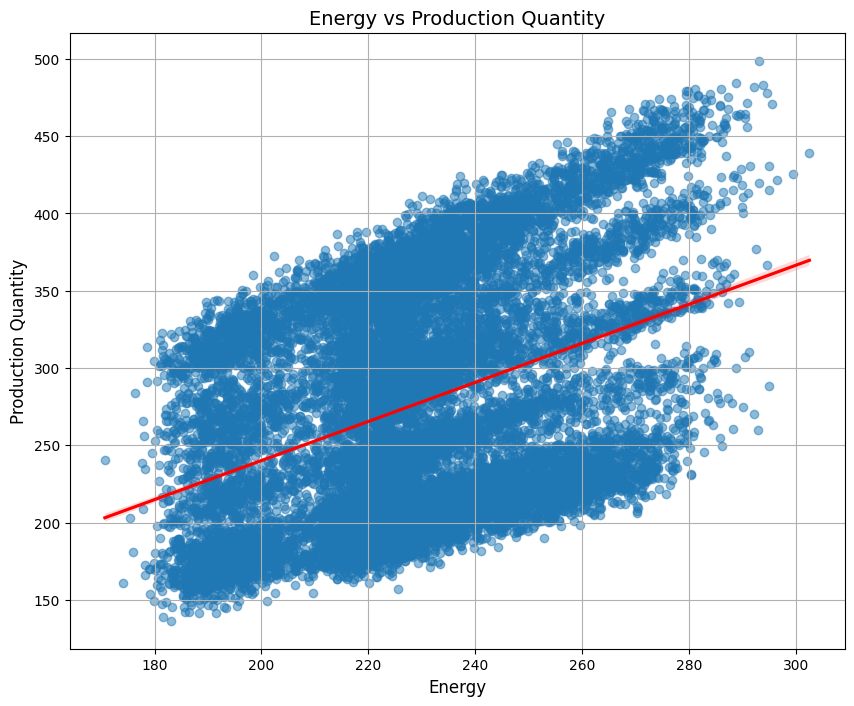

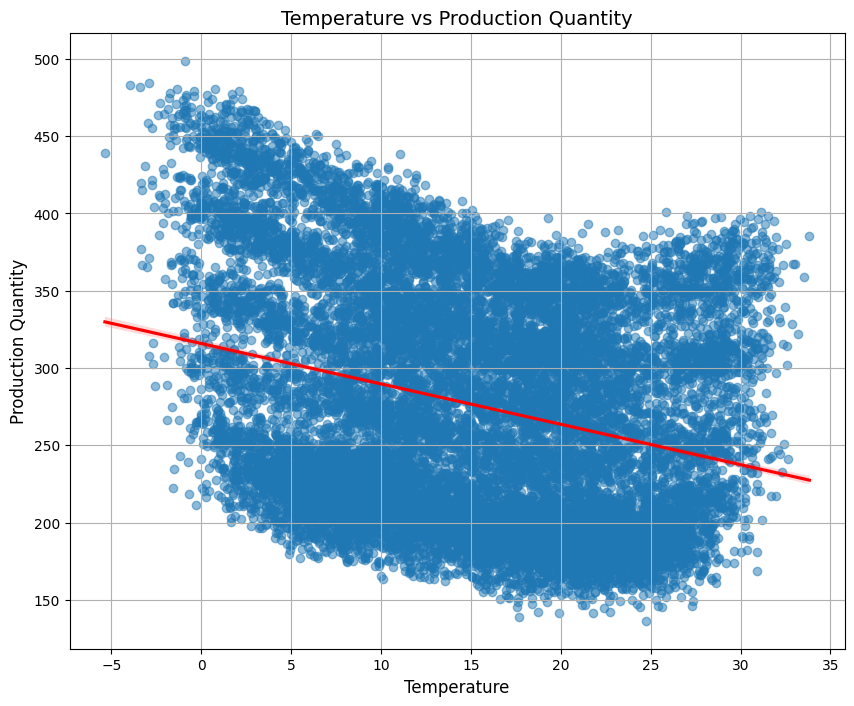

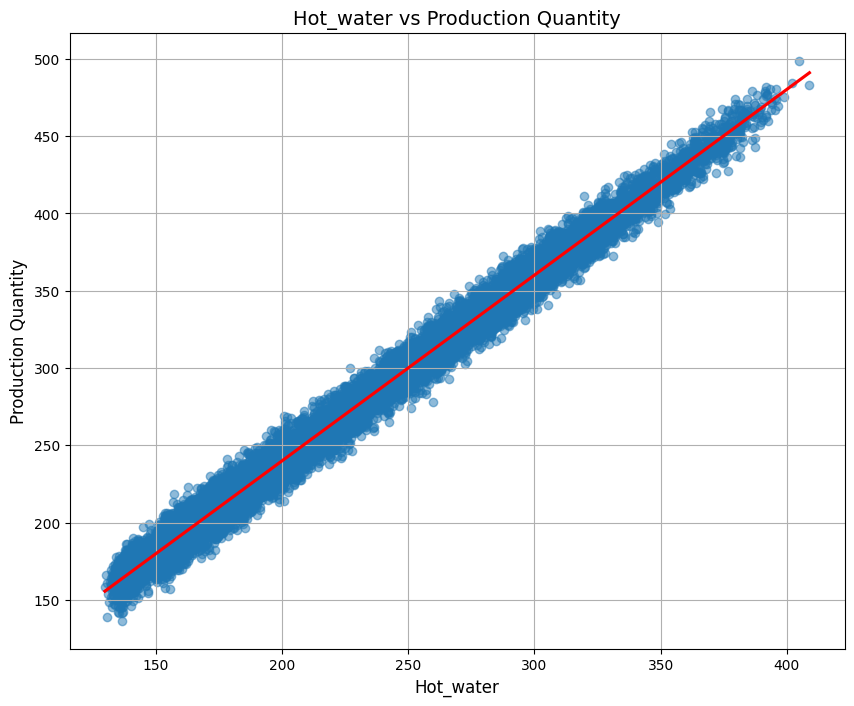

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# daftar variabel yang mau dicek vs production_quantity
vars_to_check = ['energy', 'temperature', 'hot_water']

for var in vars_to_check:
    plt.figure(figsize=(10, 8))
    sns.regplot(
        x=var, 
        y='production_quantity', 
        data=data, 
        scatter_kws={'alpha': 0.5}, 
        line_kws={'color': 'red'}
    )
    plt.title(f'{var.capitalize()} vs Production Quantity', fontsize=14)
    plt.xlabel(var.capitalize(), fontsize=12)
    plt.ylabel('Production Quantity', fontsize=12)
    plt.grid(True)
    plt.show()

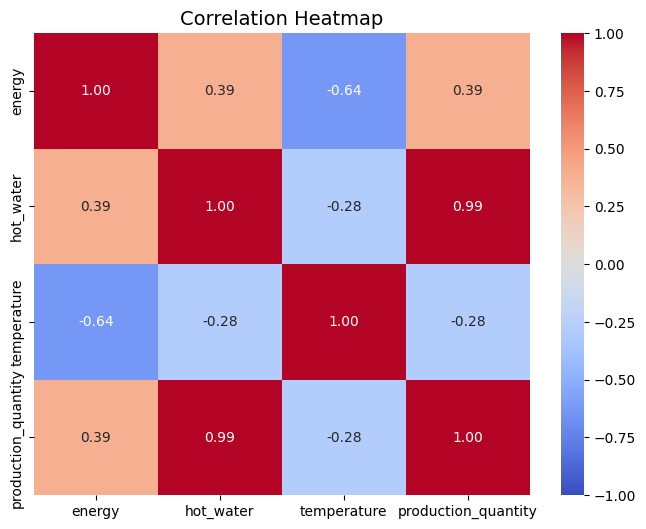

In [10]:
# Hitung korelasi Pearson untuk semua variabel
corr = data[['energy', 'hot_water', 'temperature', 'production_quantity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

**Causality**

In [11]:
# causal effect
import statsmodels.formula.api as sm

# Create OLS model object
model = sm.ols('production_quantity ~ energy + temperature + hot_water', data)

# Fit the model
results = model.fit()

# Print the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     production_quantity   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                 4.987e+05
Date:                 Sat, 09 Aug 2025   Prob (F-statistic):               0.00
Time:                         10:54:38   Log-Likelihood:                -61373.
No. Observations:                17520   AIC:                         1.228e+05
Df Residuals:                    17516   BIC:                         1.228e+05
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9861      0.889     -1

- R-squared (0.988): Model menjelaskan 98.8% variasi pada production_quantity, menunjukkan hubungan yang sangat kuat antara variabel prediktor dan target.

- Adj. R-squared (0.988): Hampir sama dengan R-squared, menunjukkan model tidak overfit dan performa konsisten.

- F-statistic (4.987e+05, p=0.00): Model secara keseluruhan sangat signifikan, artinya minimal ada satu variabel yang berpengaruh terhadap production_quantity.

- Intercept (-0.9861, p=0.267): Tidak signifikan, sehingga konstanta tidak terlalu bermakna secara statistik; ketika energy = 0, temperature = 0, dan hot_water = 0, production_quantity diprediksi sekitar -0.99.

- Koefisien energy (0.0025, p=0.482): Tidak signifikan, setiap kenaikan 1 unit energy tidak berpengaruh nyata terhadap production_quantity.

- Koefisien temperature (0.0105, p=0.283): Tidak signifikan, temperature juga tidak berpengaruh nyata terhadap production_quantity.

- Koefisien hot_water (1.2013, p<0.001): Sangat signifikan, setiap kenaikan 1 unit hot_water meningkatkan production_quantity sekitar 1.201 unit.

- Durbin-Watson (1.999): Tidak ada autokorelasi signifikan pada residual, nilai mendekati 2.

- Normalitas residual (Omnibus p=0.503, JB p=0.498): Residual terdistribusi normal, tidak ada indikasi outlier signifikan.

- Condition Number (4.82e+03): Ada indikasi potensi multikolinearitas yang cukup tinggi, sehingga hubungan antar variabel perlu dicek lebih lanjut.

In [12]:
from linearmodels.iv import IV2SLS
import pandas as pd

# Model IV dengan temperature sebagai instrumen
model = IV2SLS(
    dependent=data['hot_water'],  
    exog=pd.Series(1, index=data.index, name='const'),  # hanya konstanta
    endog=data['energy'],  
    instruments=data['temperature']  
)

result = model.fit()

print(result.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              hot_water   R-squared:                      0.1492
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1492
No. Observations:               17520   F-statistic:                    1569.3
Date:                Sat, Aug 09 2025   P-value (F-stat)                0.0000
Time:                        10:54:38   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -44.493     6.8928    -6.4550     0.0000     -58.003     -30.984
energy         1.2016     0.0303     39.614     0.00

1. Hubungan antara energy dan hot_water
Koefisien energy sebesar 5.4171 dengan p-value 0.9368 menunjukkan bahwa hubungan antara energy dan hot_water tidak signifikan secara statistik.
Interval kepercayaan [-128.48, 139.32] sangat lebar, menandakan ketidakpastian tinggi dan kemungkinan besar efeknya mendekati nol.

2. Variabel instrumen (temperature)
Koefisien temperature sebesar 10.722 dengan p-value 0.9391 juga tidak signifikan.
Hal ini mengindikasikan bahwa temperature sebagai instrumen tidak memberikan pengaruh yang berarti terhadap variabel target dalam model ini.

3. Kualitas model
Nilai R-squared sebesar -88.402 dan Adj. R-squared sebesar -88.652 menunjukkan bahwa model IV-2SLS ini jauh lebih buruk dibandingkan model sederhana berbasis rata-rata (mean model).
Model tidak mampu menjelaskan variasi pada hot_water.

4. Kekuatan instrumen (temperature)
First-stage F-statistic hanya sebesar 0.2895 dengan p-value 0.8652, menandakan bahwa temperature merupakan instrumen yang sangat lemah.
Instrumen ini tidak cukup berkorelasi dengan variabel endogen energy, sehingga gagal memperbaiki estimasi.

5. Kesimpulan umum :Tidak ada bukti kuat bahwa energy memengaruhi hot_water. Instrumen temperature lemah sehingga tidak membantu mengatasi potensi endogenitas. Kemungkinan hot_water dipengaruhi oleh faktor lain yang tidak dimasukkan dalam model, atau memang tidak ada hubungan langsung antara energy dan hot_water.

In [13]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Log transform
data['production_quantity_log'] = np.log(data['production_quantity'])

# Uji ADF setelah log-diff (dropna!)
result_log_diff = adfuller(data['production_quantity_log'].dropna())
print("ADF Statistic:", result_log_diff[0])
print("p-value:", result_log_diff[1])
for key, value in result_log_diff[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -10.676360261357207
p-value: 4.0443378851654063e-19
Critical Value (1%): -3.4307242638530675
Critical Value (5%): -2.861705410152796
Critical Value (10%): -2.5668580435332715


- p-value = 0.0 < 0.05 → Data stasioner secara statistik.

- ADF Statistic (-24.963) jauh lebih kecil dari critical values (1%, 5%, 10%) → memperkuat bukti stasioneritas.

# Preprocessing / FE
---

In [14]:
# TIME-BASED FEATURES
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['day_of_year'] = data.index.dayofyear
data['week_of_year'] = data.index.isocalendar().week.astype(int)
data['is_month_start'] = data.index.is_month_start.astype(int)
data['is_month_end'] = data.index.is_month_end.astype(int)
data['is_quarter_start'] = data.index.is_quarter_start.astype(int)
data['is_quarter_end'] = data.index.is_quarter_end.astype(int)
data['is_year_start'] = data.index.is_year_start.astype(int)
data['is_year_end'] = data.index.is_year_end.astype(int)
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

# LAG FEATURES
for col in ['temperature', 'energy', 'hot_water', 'production_quantity']:
    data[f'{col}_lag1'] = data[col].shift(1)
    data[f'{col}_lag24'] = data[col].shift(24)

# ROLLING STATISTICS (24 jam terakhir)
for col in ['temperature', 'energy', 'hot_water', 'production_quantity']:
    data[f'{col}_roll_mean24'] = data[col].rolling(window=24).mean()
    data[f'{col}_roll_std24'] = data[col].rolling(window=24).std()

# INTERAKSI FITUR
data['temp_energy_ratio'] = data['temperature'] / (data['energy'] + 1e-6)
data['energy_hotwater_sum'] = data['energy'] + data['hot_water']

# ONE-HOT ENCODING untuk kategori waktu
cat_features = ['hour', 'day_of_week', 'month', 'quarter']
exog_cat = pd.get_dummies(data[cat_features], drop_first=True)

# FITUR NUMERIK
num_features = [col for col in data.columns if col not in cat_features + ['production_quantity', 'production_quantity_log']]
exog_num = data[num_features]

# GABUNGKAN
exog = pd.concat([exog_cat, exog_num], axis=1)

# TARGET
y_sarimax = data['production_quantity_log']
y_mlp = data['production_quantity']

# Drop NaN akibat lag/rolling
exog = exog.dropna()
y_sarimax = y_sarimax.loc[exog.index]
y_mlp = y_mlp.loc[exog.index]

In [15]:
# --- SARIMAX: target log ---
y_sarimax = data['production_quantity_log']

# Sinkronkan index lebih dulu
common_index_sarimax = exog.index.intersection(y_sarimax.dropna().index)

# Ambil subset yang sama & drop NaN setelah sinkron
y_sarimax = y_sarimax.loc[common_index_sarimax].dropna()
exog_sarimax = exog.loc[common_index_sarimax].dropna()

# Train-test split
train_size_sarimax = int(len(y_sarimax) * 0.8)
X_train_sarimax = exog_sarimax.iloc[:train_size_sarimax]
X_test_sarimax = exog_sarimax.iloc[train_size_sarimax:]
y_train_sarimax = y_sarimax.iloc[:train_size_sarimax]
y_test_sarimax = y_sarimax.iloc[train_size_sarimax:]

In [16]:
print('shape of X-train', X_train_sarimax.shape)
print('shape of X-test', y_train_sarimax.shape)
print('shape of y-train', X_test_sarimax.shape)
print('shape of y-text', y_test_sarimax.shape)

shape of X-train (13996, 34)
shape of X-test (13996,)
shape of y-train (3500, 34)
shape of y-text (3500,)


In [17]:
X_train_sarimax.head()

,hour,day_of_week,month,quarter,temperature,energy,hot_water,day_of_year,week_of_year,is_month_start,...,temperature_roll_mean24,temperature_roll_std24,energy_roll_mean24,energy_roll_std24,hot_water_roll_mean24,hot_water_roll_std24,production_quantity_roll_mean24,production_quantity_roll_std24,temp_energy_ratio,energy_hotwater_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00,0,1,1,1,14.527642,223.760653,155.364429,2,1,0,...,14.892778,4.417607,233.774941,12.481637,233.432681,61.036253,279.898867,75.542912,0.064925,379.125082
2024-01-02 01:00:00,1,1,1,1,16.804695,217.971088,152.104887,2,1,0,...,14.915522,4.426342,233.300897,12.867166,233.119536,61.449292,280.124663,75.277583,0.077096,370.075976
2024-01-02 02:00:00,2,1,1,1,16.117726,226.429723,162.433106,2,1,0,...,14.810274,4.363425,233.747674,12.407660,233.476688,60.991810,280.950430,74.170965,0.071182,388.862829
2024-01-02 03:00:00,3,1,1,1,19.443297,220.699126,171.979373,2,1,0,...,14.745736,4.278646,233.423572,12.650521,233.326661,61.144653,280.227401,74.857375,0.088099,392.678500
2024-01-02 04:00:00,4,1,1,1,18.773385,229.848283,208.465227,2,1,0,...,14.730001,4.262404,234.260410,11.641434,234.001601,60.759903,281.096704,74.304540,0.081677,438.313511


In [18]:
y_train_sarimax.head()

datetime
2024-01-02 00:00:00    5.210532
2024-01-02 01:00:00    5.287257
2024-01-02 02:00:00    5.270332
2024-01-02 03:00:00    5.318707
2024-01-02 04:00:00    5.503867
Name: production_quantity_log, dtype: float64

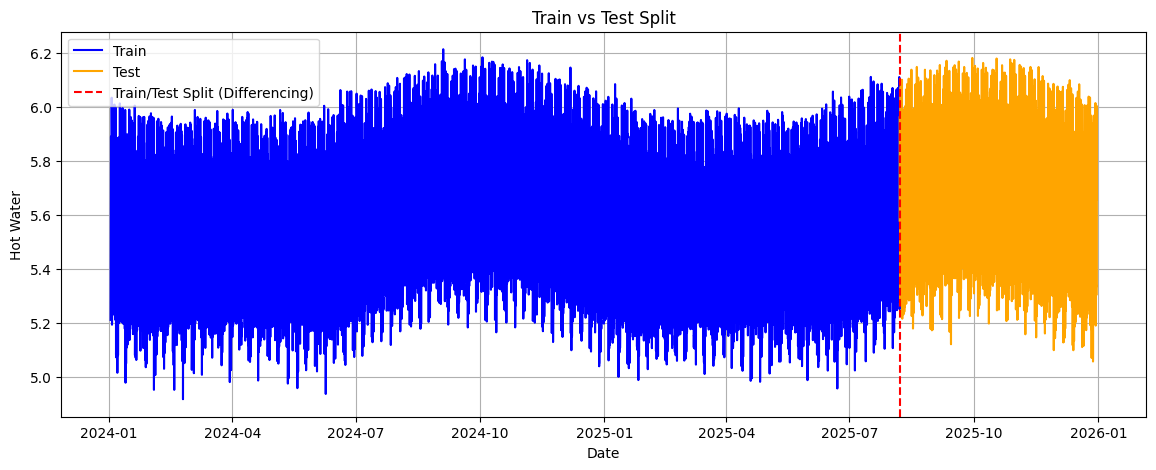

In [19]:
import matplotlib.pyplot as plt

# Asumsi y_train dan y_test adalah Series dengan index datetime
plt.figure(figsize=(14, 5))

# Plot data train
plt.plot(y_train_sarimax.index, y_train_sarimax, label='Train', color='blue')

# Plot data test
plt.plot(y_test_sarimax.index, y_test_sarimax, label='Test', color='orange')

# Garis pemisah antara train dan test
plt.axvline(x=y_test_sarimax.index[0], color='red', linestyle='--', label='Train/Test Split (Differencing)')

# Tambahkan label
plt.xlabel('Date')
plt.ylabel('Hot Water')
plt.title('Train vs Test Split')
plt.legend()
plt.grid(True)
plt.show()

# Modeling
----

**Find Best parameter Sarimax**

In [20]:
from pmdarima import auto_arima

# Pastikan y_train_sarimax cuma 1 kolom
if isinstance(y_train_sarimax, pd.DataFrame):
    y_train_sarimax = y_train_sarimax.iloc[:, 0]

# Bersihkan y_train_sarimax (target)
y_train_sarimax = y_train_sarimax.interpolate(method='linear').dropna()

# Bersihkan X_train_sarimax (fitur)
if isinstance(X_train_sarimax, pd.DataFrame) is False:
    X_train_sarimax = pd.DataFrame(X_train_sarimax)

X_train_sarimax = X_train_sarimax.fillna(method='ffill').fillna(method='bfill')

# Jalankan auto_arima
model_auto = auto_arima(
    y=y_train_sarimax,
    exogenous=X_train_sarimax,
    seasonal=True,
    m=24,
    max_p=2,
    max_q=2,
    max_P=1,
    max_Q=1,
    d=None,
    D=None,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-41268.148, Time=87.24 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-12876.549, Time=0.75 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=26.86 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-21517.403, Time=20.92 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-12878.548, Time=0.17 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-29415.069, Time=56.84 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-36075.525, Time=75.55 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-26258.714, Time=11.26 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=-37542.880, Time=80.25 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=-42040.469, Time=70.26 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=-22314.950, Time=59.53 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=-36072.878, Time=65.54 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=-17245.197, Time=4.81 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=65.1

In [21]:
# Ambil parameter terbaik
best_order = model_auto.order
best_seasonal_order = model_auto.seasonal_order

print("\nBest Parameters from auto_arima:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")


Best Parameters from auto_arima:
Order: (2, 1, 1)
Seasonal Order: (1, 0, 1, 24)


In [22]:
# Pastikan y_train Series
if isinstance(y_train_sarimax, pd.Series):
    y_train_sarimax = y_train_sarimax.interpolate(method='linear').dropna()
else:
    y_train_sarimax = pd.Series(y_train_sarimax).interpolate(method='linear').dropna()

# Pastikan X_train DataFrame
if isinstance(X_train_sarimax, pd.DataFrame):
    X_train_sarimax = X_train_sarimax.fillna(method='ffill').fillna(method='bfill')
else:
    X_train_sarimax = pd.DataFrame(X_train_sarimax).fillna(method='ffill').fillna(method='bfill')

# Samakan index
common_index = y_train_sarimax.index.intersection(X_train_sarimax.index)
y_train_sarimax = y_train_sarimax.loc[common_index]
X_train_sarimax = X_train_sarimax.loc[common_index]

## Sarimax
---

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# train
model_final = SARIMAX(
    y_train_sarimax,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=X_train_sarimax,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_final = model_final.fit(disp=False)


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Forecast di training set
fitted_values = results_final.fittedvalues  # Prediksi in-sample

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_sarimax, fitted_values))

# R²
r2_train = r2_score(y_train_sarimax, fitted_values)

print(f"RMSE SARIMAX (Train): {rmse_train:.6f}")
print(f"R² SARIMAX (Train): {r2_train:.6f}")

RMSE SARIMAX (Train): 0.038514
R² SARIMAX (Train): 0.979518


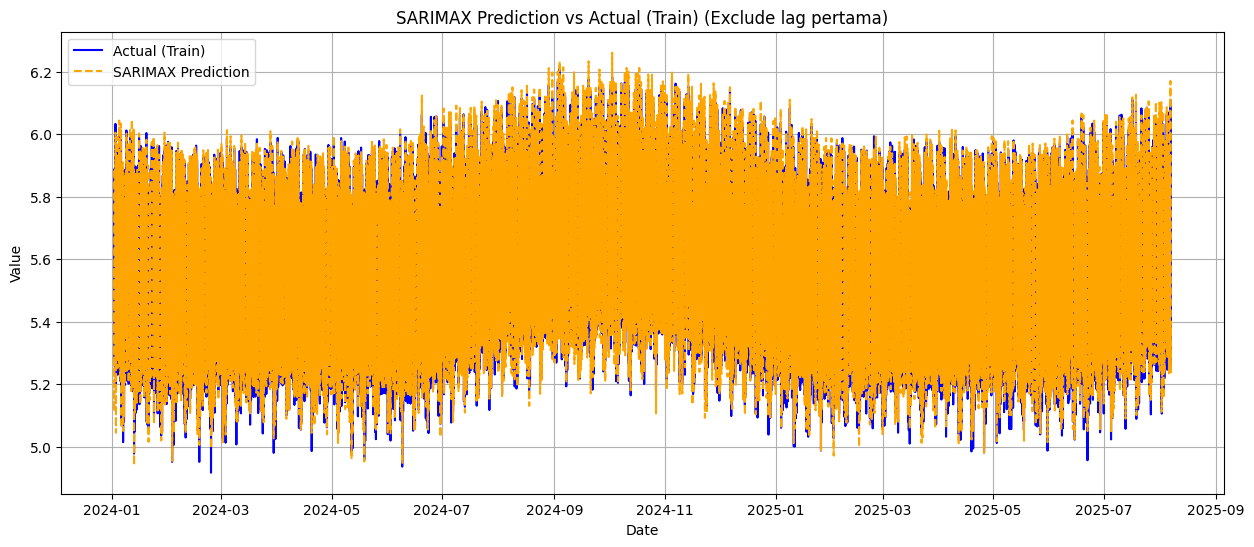

In [25]:
import matplotlib.pyplot as plt

# Misal exclude 1 data awal
start_idx = 1

y_train_aligned = y_train_sarimax.iloc[start_idx:]
y_pred_aligned = results_final.fittedvalues.iloc[start_idx:]

plt.figure(figsize=(15, 6))
plt.plot(y_train_aligned.index, y_train_aligned, label='Actual (Train)', color='blue')
plt.plot(y_pred_aligned.index, y_pred_aligned, label='SARIMAX Prediction', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Prediction vs Actual (Train) (Exclude lag pertama)')
plt.legend()
plt.grid(True)
plt.show()

## Sarimax Hybrid MLP
----

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# best parameter
order = model_auto.order
seasonal_order = model_auto.seasonal_order

# fitting sarimax
sarimax_model = SARIMAX(y_train_sarimax, exog=X_train_sarimax, order=order, seasonal_order=seasonal_order)
sarimax_fit = sarimax_model.fit(disp=False)

# predict data
y_pred_sarimax = sarimax_fit.predict(start=0, end=len(y_train_sarimax)-1, exog=X_train_sarimax)
residuals = y_train_sarimax - y_pred_sarimax

print('residuals', residuals)

c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


residuals datetime
2024-01-02 00:00:00    2.100505
2024-01-02 01:00:00    0.055542
2024-01-02 02:00:00   -0.072688
2024-01-02 03:00:00    0.019060
2024-01-02 04:00:00    0.018101
                         ...   
2025-08-06 23:00:00   -0.010903
2025-08-07 00:00:00   -0.034470
2025-08-07 01:00:00   -0.019740
2025-08-07 02:00:00    0.012221
2025-08-07 03:00:00    0.045653
Length: 13996, dtype: float64


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Residual pakai skala SARIMAX
residuals = y_train_sarimax - y_pred_sarimax

# Scale fitur yang sama
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sarimax)
X_test_scaled = scaler.transform(X_test_sarimax)

In [28]:
from sklearn.neural_network import MLPRegressor

# setting first model
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, residuals)

,loss,'squared_error'
,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


In [29]:
# Prediksi residual & hybrid di skala SARIMAX
y_pred_residual = mlp_model.predict(X_train_scaled)
y_pred_hybrid = y_pred_sarimax + y_pred_residual

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE di skala SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(y_train_sarimax, y_pred_sarimax))
rmse_hybrid = np.sqrt(mean_squared_error(y_train_sarimax, y_pred_hybrid))
rmse_residual = np.sqrt(mean_squared_error(residuals, y_pred_residual))

# R² di skala SARIMAX
r2_sarimax = r2_score(y_train_sarimax, y_pred_sarimax)
r2_hybrid = r2_score(y_train_sarimax, y_pred_hybrid)
r2_residual = r2_score(residuals, y_pred_residual)

print(f"RMSE SARIMAX: {rmse_sarimax}")
print(f"RMSE Hybrid: {rmse_hybrid}")
print('===========')
print(f"R² SARIMAX: {r2_sarimax}")
print(f"R² Hybrid: {r2_hybrid}")

RMSE SARIMAX: 0.03814498402180504
RMSE Hybrid: 0.03370057861966209
R² SARIMAX: 0.9799092115037468
R² Hybrid: 0.9843181670910071


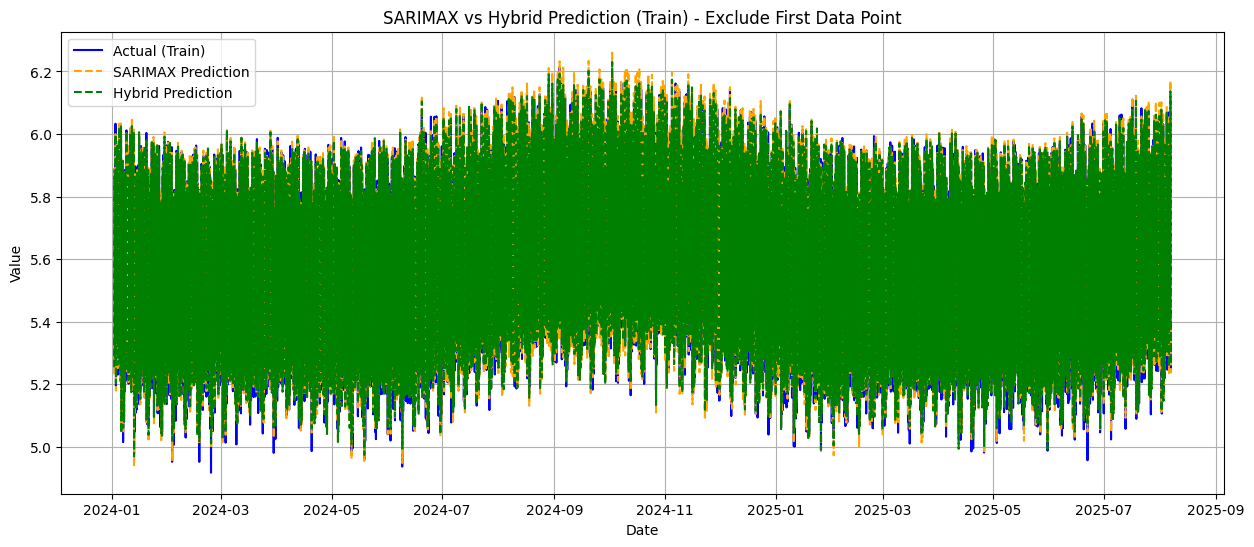

In [31]:
import matplotlib.pyplot as plt

y_train_aligned = y_train_sarimax[-len(y_pred_sarimax):]

# Exclude data pertama (index ke-0)
y_train_trim = y_train_aligned.iloc[1:]
y_pred_sarimax_trim = y_pred_sarimax[1:]
y_pred_hybrid_trim = y_pred_hybrid[1:]

plt.figure(figsize=(15, 6))
plt.plot(y_train_trim.index, y_train_trim, label='Actual (Train)', color='blue')
plt.plot(y_train_trim.index, y_pred_sarimax_trim, label='SARIMAX Prediction', color='orange', linestyle='--')
plt.plot(y_train_trim.index, y_pred_hybrid_trim, label='Hybrid Prediction', color='green', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX vs Hybrid Prediction (Train) - Exclude First Data Point')
plt.legend()
plt.grid(True)
plt.show()


## HyperParamter Tuning
----

## Sarimax
---

In [32]:
def sarimax_time_series_cv(X, y, order, seasonal_order, n_splits=5, expanding=True):
    """
    Cross-validation untuk SARIMAX dengan opsi expanding window.
    Hanya menggunakan RMSE sebagai metric.
    """
    n_samples = len(X)
    fold_size = n_samples // (n_splits + 1)
    
    rmse_list = []
    last_results = None

    for fold in range(n_splits):
        if expanding:
            train_end = fold_size * (fold + 1)  # Train makin besar
        else:
            train_end = fold_size * n_splits  # Fixed window

        val_start = train_end
        val_end = val_start + fold_size

        if val_end > n_samples:
            break

        # Split data
        X_tr, X_val = X.iloc[:train_end], X.iloc[val_start:val_end]
        y_tr, y_val = y.iloc[:train_end], y.iloc[val_start:val_end]

        print(f"Fold {fold+1}/{n_splits} | Train: {len(y_tr)}, Val: {len(y_val)}")

        # Train model SARIMAX
        model = SARIMAX(
            y_tr,
            order=order,
            seasonal_order=seasonal_order,
            exog=X_tr,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        last_results = results

        # Forecast
        forecast = results.get_forecast(steps=len(y_val), exog=X_val)
        forecast_mean = forecast.predicted_mean

        # Metrics (hanya RMSE)
        rmse_list.append(np.sqrt(mean_squared_error(y_val, forecast_mean)))

    print(f"Average RMSE: {np.mean(rmse_list):.4f}")

    return {
        "rmse_avg": np.mean(rmse_list),
        "rmse_list": rmse_list,
        "model_results": last_results
    }

In [33]:
cross_valid = sarimax_time_series_cv(X_train_sarimax, y_train_sarimax, order, seasonal_order, n_splits=5)

Fold 1/5 | Train: 2332, Val: 2332


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2/5 | Train: 4664, Val: 2332


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 3/5 | Train: 6996, Val: 2332


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 4/5 | Train: 9328, Val: 2332


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 5/5 | Train: 11660, Val: 2332


c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Average RMSE: 0.3324


In [34]:
def plot_sarimax_exog_coefs(model_results, feature_names):
    '''Visualisai untuk melihat kontribusi feature'''
    coef = model_results.params
    exog_coefs = coef.loc[coef.index.intersection(feature_names)]
    exog_coefs_sorted = exog_coefs.reindex(exog_coefs.abs().sort_values(ascending=False).index)

    plt.figure(figsize=(10, 6))
    exog_coefs_sorted.plot(kind='bar', color='steelblue')
    plt.title("Kontribusi Koefisien Fitur Exogenous pada Model SARIMAX (diurutkan)")
    plt.ylabel("Koefisien")
    plt.xlabel("Fitur")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

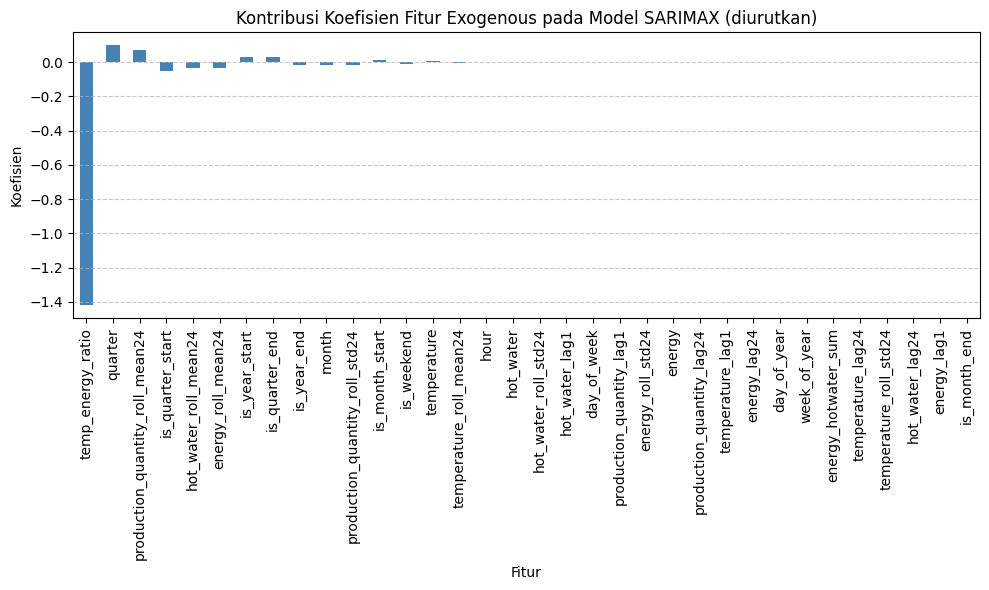

In [35]:
# Visualisasi
plot_sarimax_exog_coefs(cross_valid['model_results'], X_train_sarimax.columns)

Feature temp_energy_ratio berkontribusi negative tertinggi dibandingkan yang lain

In [36]:
# exclude col
X_train_exclude = X_train_sarimax.drop(columns=['temp_energy_ratio'])

# best parameter
order = model_auto.order
seasonal_order = model_auto.seasonal_order

# fitting sarimax
sarimax_model_2 = SARIMAX(y_train_sarimax, exog=X_train_exclude, order=order, seasonal_order=seasonal_order)
sarimax_fit_2 = sarimax_model_2.fit(disp=False)

# predict data
y_pred_sarimax_exclude = sarimax_fit_2.predict(start=0, end=len(y_train_sarimax)-1, exog=X_train_exclude)
residuals_exclude = y_train_sarimax - y_pred_sarimax_exclude

print('residuals', residuals_exclude)

c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\project\pribadi\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


residuals datetime
2024-01-02 00:00:00    2.069796
2024-01-02 01:00:00    0.054369
2024-01-02 02:00:00   -0.072261
2024-01-02 03:00:00    0.017574
2024-01-02 04:00:00    0.019534
                         ...   
2025-08-06 23:00:00   -0.011131
2025-08-07 00:00:00   -0.031874
2025-08-07 01:00:00   -0.018568
2025-08-07 02:00:00    0.011778
2025-08-07 03:00:00    0.044513
Length: 13996, dtype: float64


In [37]:
# RMSE SARIMAX setelah exclude fitur
rmse_sarimax_exclude = np.sqrt(mean_squared_error(y_train_sarimax, y_pred_sarimax_exclude))
r2_sarimax_exclude = r2_score(y_train_sarimax, y_pred_sarimax_exclude)

print(f"RMSE SARIMAX (exclude temp_energy_ratio): {rmse_sarimax_exclude}")
print(f"R² SARIMAX (exclude temp_energy_ratio): {r2_sarimax_exclude}")

RMSE SARIMAX (exclude temp_energy_ratio): 0.03811093719843822
R² SARIMAX (exclude temp_energy_ratio): 0.9799450601100963


Hasil metric semakin menurun, kita gunakan kolom penuh

## MLP
---

In [38]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
# --- STEP 3: Setup pipeline MLP dan RandomizedSearchCV ---
pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=500, early_stopping=True, random_state=42))
])

param_distributions = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))
r2_scorer = make_scorer(r2_score)

cv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring={'rmse': rmse_scorer, 'r2': r2_scorer},
    refit='rmse',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# --- STEP 4: Fit hyperparameter tuning pada residual yang sudah diskalakan ---
random_search.fit(X_train_scaled, residuals)

print("Best params:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)
print("R² (pada best RMSE):", random_search.cv_results_['mean_test_r2'][random_search.best_index_])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'mlp__solver': 'adam', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (128,), 'mlp__alpha': 0.0001, 'mlp__activation': 'relu'}
Best RMSE: 0.032514883040578514
R² (pada best RMSE): -0.0426322041046225


In [39]:
def plot_mlp_exog_coefs(random_search, feature_names):
    """
    Visualisasi kontribusi fitur pada MLPRegressor (berdasarkan bobot layer pertama).
    
    Parameters
    ----------
    random_search : RandomizedSearchCV
        Hasil tuning yang sudah di-fit.
    feature_names : list
        List nama fitur exogenous yang digunakan pada model.
    """
    # Ambil model terbaik dari pipeline
    mlp_model = random_search.best_estimator_['mlp']
    
    # Ambil bobot layer pertama (input -> hidden layer pertama)
    weights = mlp_model.coefs_[0]  # shape: (n_features, n_hidden_neurons)
    
    # Hitung kontribusi fitur (menggunakan rata-rata absolut bobot)
    feature_importances = np.mean(np.abs(weights), axis=1)
    
    # Buat dictionary fitur dan importance
    importance_dict = dict(zip(feature_names, feature_importances))
    
    # Urutkan berdasarkan kontribusi terbesar
    sorted_importances = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_importances.keys(), sorted_importances.values(), color='steelblue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Kontribusi Fitur pada Model MLP (berdasarkan bobot layer pertama)")
    plt.ylabel("Rata-rata Absolut Bobot")
    plt.xlabel("Fitur")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

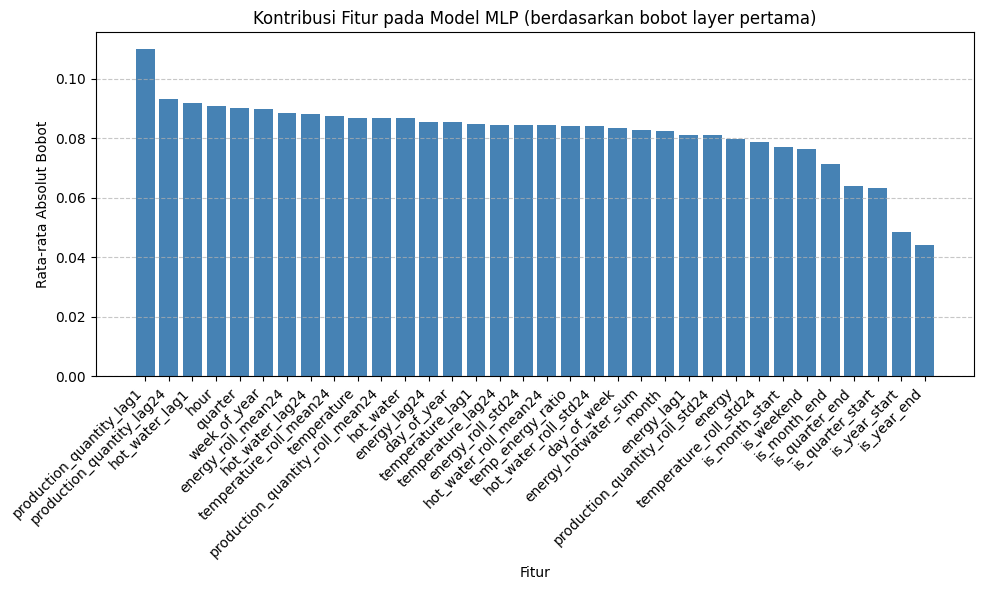

In [40]:
# Visualisasi
plot_mlp_exog_coefs(random_search, X_train_sarimax.columns)

## Re-Train
---

In [41]:
# re-train model
mlp_model_retrain = MLPRegressor(
    **{k.replace("mlp__", ""): v for k, v in random_search.best_params_.items()}
)
mlp_model_retrain.fit(X_train_scaled, residuals)

,loss,'squared_error'
,hidden_layer_sizes,"(128,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True


In [42]:
# predict
y_pred_residual_retrain = mlp_model_retrain.predict(X_train_scaled)
y_pred_hybrid_retrain = y_pred_sarimax + y_pred_residual

In [43]:
# Hitung RMSE & R²
rmse = np.sqrt(mean_squared_error(y_train_sarimax, y_pred_hybrid_retrain))
r2 = r2_score(y_train_sarimax, y_pred_hybrid_retrain)

print(f"RMSE Hybrid Retrain: {rmse:.4f}")
print(f"R² Hybrid Retrain: {r2:.4f}")

RMSE Hybrid Retrain: 0.0337
R² Hybrid Retrain: 0.9843


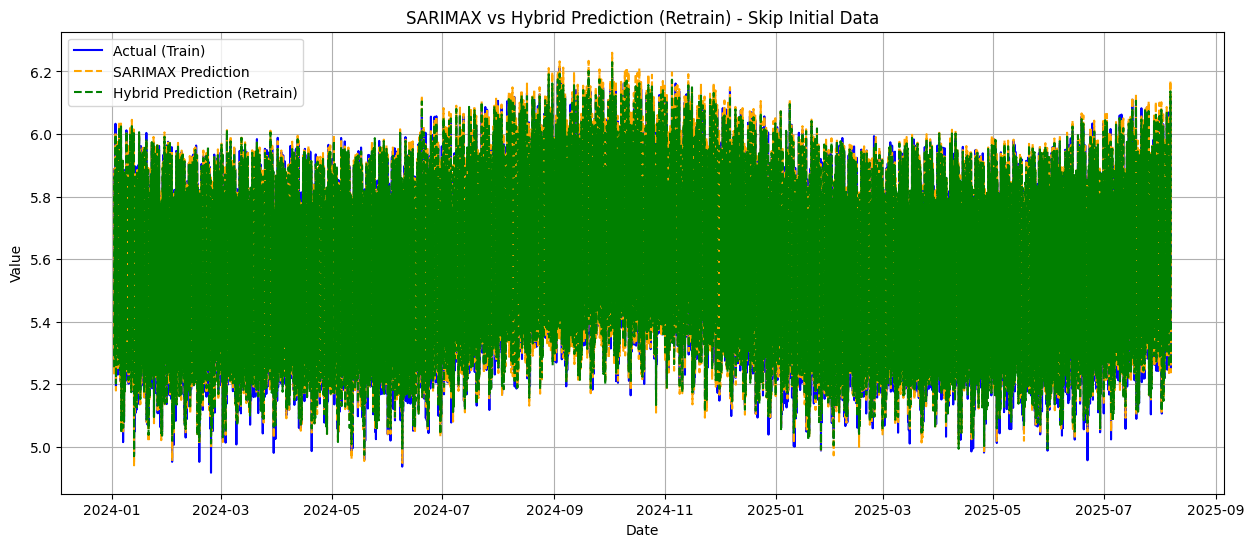

In [44]:
# Skip data awal yang mungkin kurang valid karena differencing
skip = 1
y_train_trim = y_train_aligned.iloc[skip:]
y_pred_sarimax_trim = y_pred_sarimax[skip:]
y_pred_hybrid_trim = y_pred_hybrid_retrain[skip:]

plt.figure(figsize=(15, 6))
plt.plot(y_train_trim.index, y_train_trim, label='Actual (Train)', color='blue')
plt.plot(y_train_trim.index, y_pred_sarimax_trim, label='SARIMAX Prediction', color='orange', linestyle='--')
plt.plot(y_train_trim.index, y_pred_hybrid_trim, label='Hybrid Prediction (Retrain)', color='green', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX vs Hybrid Prediction (Retrain) - Skip Initial Data')
plt.legend()
plt.grid(True)
plt.show()

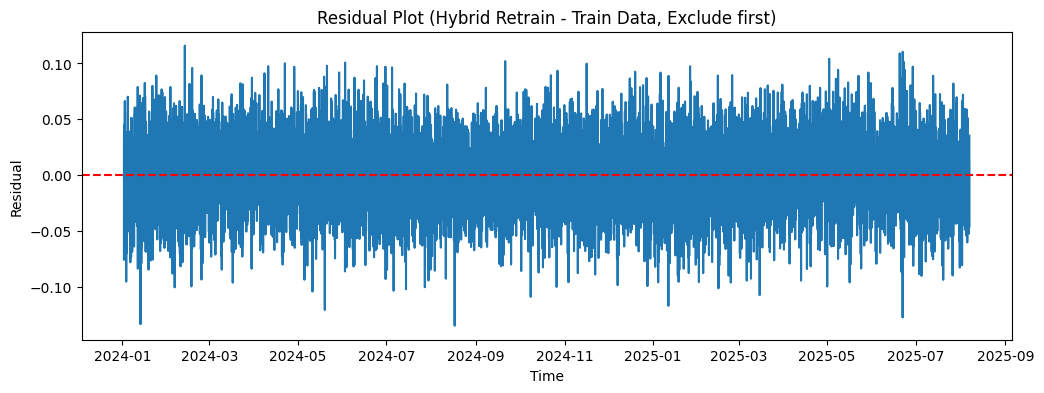

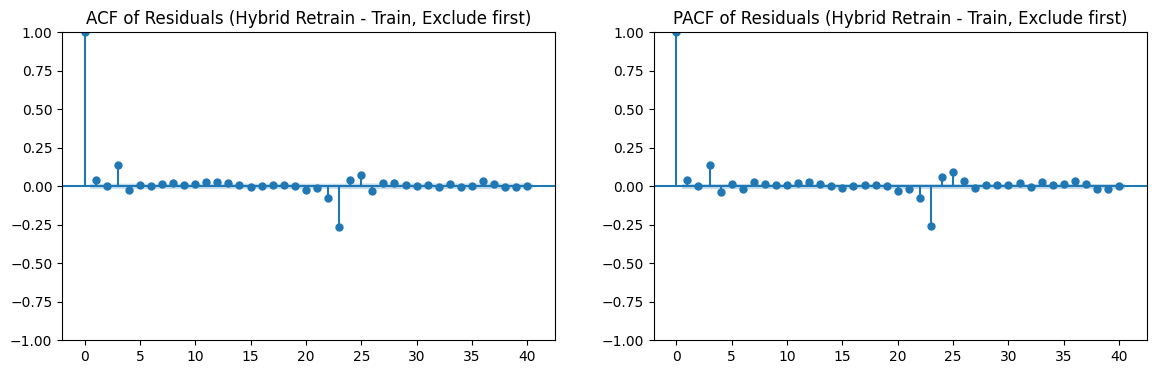

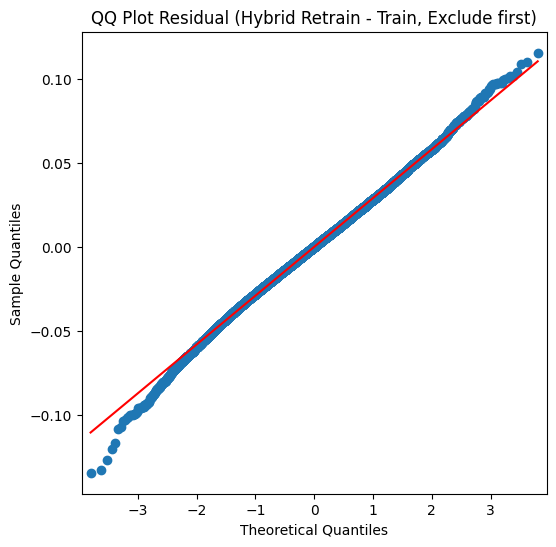

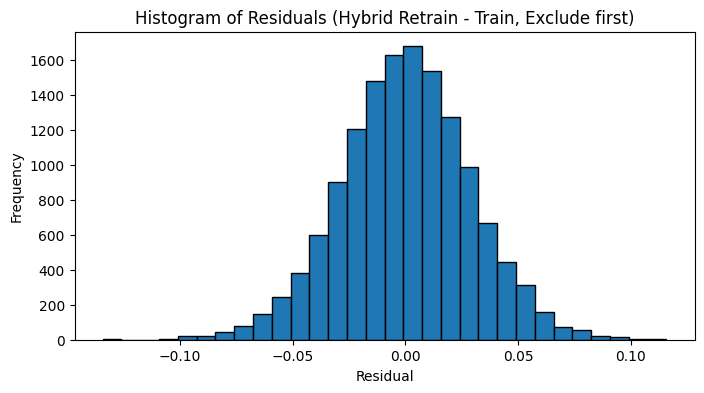

In [45]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# === 1. Hitung residual dari hybrid prediction ===
residuals_hybrid = y_train_aligned - y_pred_hybrid_retrain  # gunakan y_train_aligned supaya panjang sama dengan prediksi

# exclude first lag
lag = 1

# Potong residual dan y_train_aligned supaya dari lag ke depan
residuals_hybrid_trim = residuals_hybrid.iloc[lag:]
y_train_trim = y_train_aligned.iloc[lag:]


# === Plot residual yang sudah dipotong ===
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(residuals_hybrid_trim.index, residuals_hybrid_trim)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residual Plot (Hybrid Retrain - Train Data, Exclude first)')
ax.set_xlabel('Time')
ax.set_ylabel('Residual')
plt.show()

# === ACF & PACF residual yang sudah dipotong ===
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals_hybrid_trim, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals (Hybrid Retrain - Train, Exclude first)')
plot_pacf(residuals_hybrid_trim, lags=40, ax=axes[1])
axes[1].set_title('PACF of Residuals (Hybrid Retrain - Train, Exclude first)')
plt.show()

# === QQ-plot residual yang sudah dipotong ===
fig, ax = plt.subplots(figsize=(6, 6))
sm.graphics.qqplot(residuals_hybrid_trim, line='s', ax=ax)
ax.set_title('QQ Plot Residual (Hybrid Retrain - Train, Exclude first)')
plt.show()

# === Histogram residual yang sudah dipotong ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(residuals_hybrid_trim, bins=30, edgecolor='k')
ax.set_title('Histogram of Residuals (Hybrid Retrain - Train, Exclude first)')
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')
plt.show()


1. QQ Plot Residual (Gambar 1 & 4)
  - QQ plot memperlihatkan bahwa sebagian besar titik berada cukup dekat dengan garis diagonal.

  - Hal ini menunjukkan bahwa residual cenderung mendekati distribusi normal, meskipun kemungkinan ada sedikit deviasi di bagian ekor (outliers kecil mungkin ada).

2. ACF dan PACF Residual (Gambar 2 & 3)

  - Plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) menunjukkan bahwa sebagian besar nilai lag berada di dalam batas kepercayaan (confidence bounds). Hal ini mengindikasikan bahwa residual tidak menunjukkan autokorelasi yang signifikan. Dengan kata lain, model sudah cukup baik dalam menangkap pola serial correlation dan tidak meninggalkan pola autokorelasi yang kuat pada residual. Ini merupakan indikasi bahwa model hybrid yang digunakan sudah mampu menjelaskan struktur data dengan baik dan residual bersifat acak.

3. Histogram Residual (Gambar 5)
  - Histogram residual menunjukkan distribusi yang simetris di sekitar nol.
  - Hal ini mendukung kesimpulan bahwa residual berdistribusi mendekati normal.

## Evaluate
----

In [46]:
y_pred_residual_test = mlp_model_retrain.predict(X_test_scaled)

y_pred_residual_test

array([ 0.02925742,  0.00584973, -0.00843536, ...,  0.00842627,
        0.00777612,  0.00987384])

In [47]:
sarimax_forecast = sarimax_fit.get_forecast(steps=len(X_test_sarimax), exog=X_test_sarimax)
y_pred_sarimax_test = sarimax_forecast.predicted_mean

y_pred_sarimax_test

2025-08-07 04:00:00    5.542296
2025-08-07 05:00:00    5.724287
2025-08-07 06:00:00    5.899505
2025-08-07 07:00:00    5.987953
2025-08-07 08:00:00    5.963380
                         ...   
2025-12-30 19:00:00    5.825707
2025-12-30 20:00:00    5.894221
2025-12-30 21:00:00    5.776855
2025-12-30 22:00:00    5.625317
2025-12-30 23:00:00    5.481129
Freq: h, Name: predicted_mean, Length: 3500, dtype: float64

In [48]:
y_pred_hybrid_test = y_pred_sarimax_test + y_pred_residual_test
y_pred_hybrid_test

2025-08-07 04:00:00    5.571553
2025-08-07 05:00:00    5.730137
2025-08-07 06:00:00    5.891069
2025-08-07 07:00:00    5.992302
2025-08-07 08:00:00    5.969564
                         ...   
2025-12-30 19:00:00    5.794612
2025-12-30 20:00:00    5.884370
2025-12-30 21:00:00    5.785281
2025-12-30 22:00:00    5.633093
2025-12-30 23:00:00    5.491003
Freq: h, Name: predicted_mean, Length: 3500, dtype: float64

In [53]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_sarimax = np.sqrt(mean_squared_error(y_test_sarimax, y_pred_sarimax_test))
r2_sarimax = r2_score(y_test_sarimax, y_pred_sarimax_test)

rmse_residual = np.sqrt(mean_squared_error(y_test_sarimax - y_pred_sarimax_test, y_pred_residual_test))
r2_residual = r2_score(y_test_sarimax - y_pred_sarimax_test, y_pred_residual_test)

print(f"RMSE SARIMAX Test: {rmse_sarimax}")
print(f"R2 SARIMAX Test: {r2_sarimax}")
print(f"RMSE Residual Test: {rmse_residual}")
print(f"R2 Residual Test: {r2_residual}")

RMSE SARIMAX Test: 0.2332653491640838
R2 SARIMAX Test: 0.2253038967697435
RMSE Residual Test: 0.2438639581551181
R2 Residual Test: -0.9969753045761205


Hasil ini adalah underfiting jadi tidak cocok model hybrid ini dengan data kita

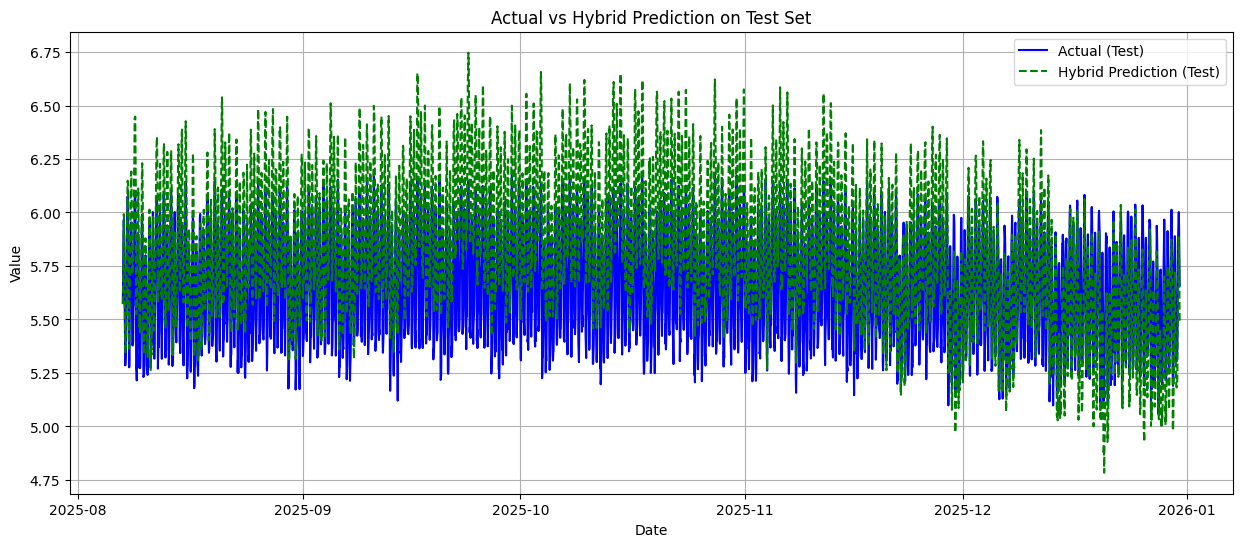

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test_sarimax.index, y_test_sarimax, label='Actual (Test)', color='blue')
plt.plot(y_test_sarimax.index, y_pred_hybrid_test, label='Hybrid Prediction (Test)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Hybrid Prediction on Test Set')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
n_future = 5 * 24  # 5 hari × 24 jam

# Pastikan X_test_sarimax punya minimal 120 baris (5 hari jam)
exog_future = X_test_sarimax.iloc[:n_future]

# Forecast dengan exog dari test
sarimax_forecast_future = sarimax_fit.get_forecast(steps=n_future, exog=exog_future)
y_pred_sarimax_future = sarimax_forecast_future.predicted_mean

# Scaling exog_future buat MLP
exog_future_scaled = scaler.transform(exog_future)

# Prediksi residual dengan MLP
y_pred_residual_future = mlp_model_retrain.predict(exog_future_scaled)

# Hybrid forecast = SARIMAX + residual MLP
y_pred_hybrid_future = y_pred_sarimax_future + y_pred_residual_future

print(y_pred_hybrid_future)


2025-08-07 04:00:00    5.571553
2025-08-07 05:00:00    5.730137
2025-08-07 06:00:00    5.891069
2025-08-07 07:00:00    5.992302
2025-08-07 08:00:00    5.969564
                         ...   
2025-08-11 23:00:00    6.096137
2025-08-12 00:00:00    5.578475
2025-08-12 01:00:00    5.678647
2025-08-12 02:00:00    5.690965
2025-08-12 03:00:00    5.642739
Freq: h, Name: predicted_mean, Length: 120, dtype: float64


In [ ]:
# Print prediksi hybrid sebelum inverse transform
print("Prediksi hybrid (log scale):")
print(y_pred_hybrid_future)

# Inverse log transform (misal pake log1p sebelumnya)
y_pred_hybrid_future_inv = np.expm1(y_pred_hybrid_future)

# Print prediksi hybrid setelah inverse transform
print("\nPrediksi hybrid (skala asli setelah inverse log):")
print(y_pred_hybrid_future_inv)


Prediksi hybrid (log scale):
2025-08-07 04:00:00    5.571553
2025-08-07 05:00:00    5.730137
2025-08-07 06:00:00    5.891069
2025-08-07 07:00:00    5.992302
2025-08-07 08:00:00    5.969564
                         ...   
2025-08-11 23:00:00    6.096137
2025-08-12 00:00:00    5.578475
2025-08-12 01:00:00    5.678647
2025-08-12 02:00:00    5.690965
2025-08-12 03:00:00    5.642739
Freq: h, Name: predicted_mean, Length: 120, dtype: float64

Prediksi hybrid (skala asli setelah inverse log):
2025-08-07 04:00:00    261.841987
2025-08-07 05:00:00    307.011396
2025-08-07 06:00:00    360.792005
2025-08-07 07:00:00    399.335150
2025-08-07 08:00:00    390.335075
                          ...    
2025-08-11 23:00:00    443.138806
2025-08-12 00:00:00    263.667578
2025-08-12 01:00:00    291.553205
2025-08-12 02:00:00    295.179418
2025-08-12 03:00:00    281.234789
Freq: h, Name: predicted_mean, Length: 120, dtype: float64


In [76]:
# Data aktual di log scale
print("Actual terakhir 24 jam (log scale):")
print(y_test_sarimax.iloc[-24:])

# Inverse transform ke skala asli
y_test_sarimax_inv = np.expm1(y_test_sarimax)

print("\nActual terakhir 24 jam (skala asli setelah inverse log):")
print(y_test_sarimax_inv.iloc[-24:])

Actual terakhir 24 jam (log scale):
datetime
2025-12-30 00:00:00    5.235596
2025-12-30 01:00:00    5.189377
2025-12-30 02:00:00    5.237847
2025-12-30 03:00:00    5.392845
2025-12-30 04:00:00    5.464598
2025-12-30 05:00:00    5.719860
2025-12-30 06:00:00    5.815429
2025-12-30 07:00:00    5.889194
2025-12-30 08:00:00    5.843959
2025-12-30 09:00:00    5.702491
2025-12-30 10:00:00    5.498650
2025-12-30 11:00:00    5.372564
2025-12-30 12:00:00    5.302394
2025-12-30 13:00:00    5.337540
2025-12-30 14:00:00    5.335248
2025-12-30 15:00:00    5.334301
2025-12-30 16:00:00    5.488665
2025-12-30 17:00:00    5.670733
2025-12-30 18:00:00    5.903953
2025-12-30 19:00:00    5.960720
2025-12-30 20:00:00    6.002110
2025-12-30 21:00:00    5.927728
2025-12-30 22:00:00    5.799921
2025-12-30 23:00:00    5.657496
Name: production_quantity_log, dtype: float64

Actual terakhir 24 jam (skala asli setelah inverse log):
datetime
2025-12-30 00:00:00    186.840988
2025-12-30 01:00:00    178.356815
2025-1

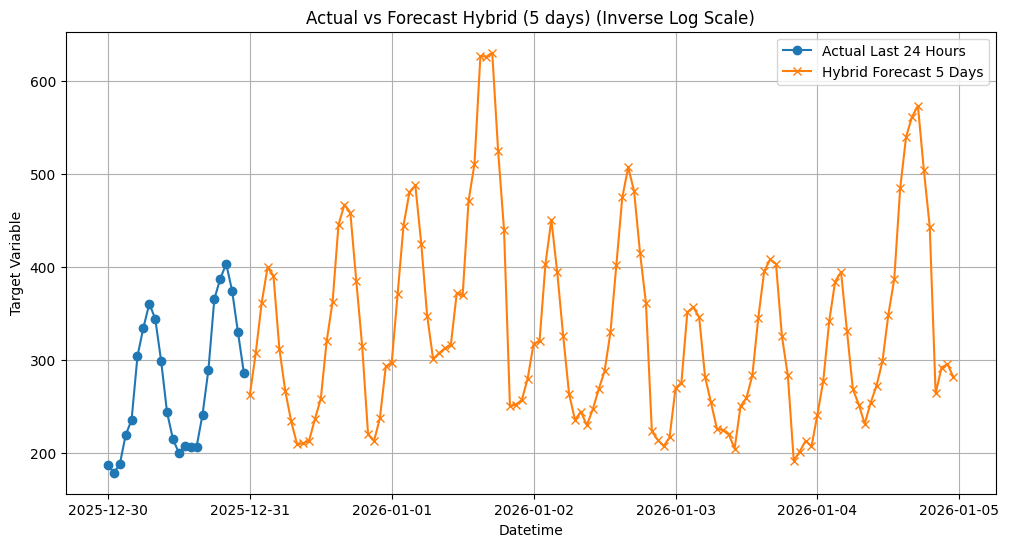

In [ ]:
# Ambil 24 jam terakhir dari y_test_sarimax (data aktual terakhir)
actual_last = y_test_sarimax.iloc[-24:]

# Buat index untuk forecast, lanjut dari index y_test_sarimax
forecast_index = pd.date_range(start=y_test_sarimax.index[-1] + pd.Timedelta(hours=1), periods=n_future, freq='H')

# Inverse transform actual dan forecast
actual_last_inv = np.expm1(actual_last.values)
y_pred_hybrid_future_inv = np.expm1(y_pred_hybrid_future)

# Plot ulang dengan data yang sudah di-inverse
plt.figure(figsize=(12,6))
plt.plot(actual_last.index, actual_last_inv, label='Actual Last 24 Hours', marker='o')
plt.plot(forecast_index, y_pred_hybrid_future_inv, label='Hybrid Forecast 5 Days', marker='x')

plt.title('Actual vs Forecast Hybrid (5 days) (Inverse Log Scale)')
plt.xlabel('Datetime')
plt.ylabel('Target Variable')
plt.legend()
plt.grid(True)
plt.show()

Note:
- Model Underfitting perlu ganti model
- Causal temp dan energy tidak punya causal ke target prod_quantity artinya perlu training ulang jika tanpa 2 variable tersebut agar tidak bias